# 3. Awkward Array

<br><br><br><br><br>

## What about an array of lists?

In [ ]:
import awkward as ak
import numpy as np
import uproot

In [ ]:
events = uproot.open("data/HZZ.root:events")
events.show()

In [ ]:
events["Muon_Px"].array()

In [ ]:
events["Muon_Px"].array(entry_stop=20).tolist()

This is what Awkward Array was made for. NumPy's equivalent is cumbersome and inefficient.

In [ ]:
jagged_numpy = events["Muon_Px"].array(entry_stop=20, library="np")
jagged_numpy

What if I want the first item in each list as an array?

In [ ]:
np.array([x[0] for x in jagged_numpy])

This violates the rule from [1-python-performance.ipynb](1-python-performance.ipynb): don't iterate in Python.

In [ ]:
jagged_awkward = events["Muon_Px"].array(entry_stop=20, library="ak")
jagged_awkward

In [ ]:
jagged_awkward[:, 0]

<br><br><br><br><br>

### Jaggedness in Pandas

It can be done by putting the distinction between events in the DataFrame index.

In [ ]:
events.arrays(filter_name="Muon_*", library="pd")

But if you want multiple particles, they can't be in the same DataFrame.

(A DataFrame has only one index; how would you relate jet subentry #1 with muon subentry #1?)

In [ ]:
dataframes = events.arrays(filter_name="/(Muon_|Jet_).*/", library="pd")

In [ ]:
len(dataframes)

In [ ]:
dataframes[0]

In [ ]:
dataframes[1]

Again, that's why we have Awkward Array.

In [ ]:
array = events.arrays(filter_name="/(Muon_|Jet_).*/", library="ak", how="zip")
array

In [ ]:
array.Jet

In [ ]:
array.Jet.Px

In [ ]:
array.Muon

In [ ]:
array.Muon.Px

In [ ]:
ak.num(array.Jet), ak.num(array.Muon)

<br><br><br><br><br>

## Awkward Array is a general-purpose library: NumPy-like idioms on JSON-like data

<img src="img/pivarski-one-slide-summary.svg" style="width: 70%">

<br><br><br><br><br>

## Main idea: slicing through structure is computationally inexpensive

Slicing by field name doesn't modify any large buffers and [ak.zip](https://awkward-array.readthedocs.io/en/latest/_auto/ak.zip.html) only scans them to ensure they're compatible (not even that if `depth_limit=1`).

In [ ]:
array = events.arrays()
array

Think of this as zero-cost:

In [ ]:
array.Muon_Px, array.Muon_Py, array.Muon_Pz

Think of this as zero-cost:

In [ ]:
ak.zip({"px": array.Muon_Px, "py": array.Muon_Py, "pz": array.Muon_Pz})

(The above is a manual version of `how="zip"`.)

<br><br><br>

NumPy ufuncs work on these arrays (if they're "[broadcastable](https://awkward-array.readthedocs.io/en/latest/_auto/ak.broadcast_arrays.html)").

In [ ]:
np.sqrt(array.Muon_Px**2 + array.Muon_Py**2)

<br><br><br>

And there are specialized operations that only make sense in a variable-length context.

<table style="margin-left: 0px">
    <tr style="background: white"><td style="font-size: 1.75em; font-weight: bold; text-align: center"><a href="https://awkward-array.readthedocs.io/en/latest/_auto/ak.cartesian.html">ak.cartesian</a></td><td style="font-size: 1.75em; font-weight: bold; text-align: center"><a href="https://awkward-array.readthedocs.io/en/latest/_auto/ak.combinations.html">ak.combinations</a></td></tr>
    <tr style="background: white"><td><img src="img/cartoon-cartesian.png"></td><td><img src="img/cartoon-combinations.png"></td></tr>
</table>

In [ ]:
ak.cartesian((array.Muon_Px, array.Jet_Px))

In [ ]:
ak.combinations(array.Muon_Px, 2)

<br><br><br><br><br>

## Arrays can have custom [behavior](https://awkward-array.readthedocs.io/en/latest/ak.behavior.html)

The following come from the new [Vector](https://github.com/scikit-hep/vector#readme) library.

In [11]:
import vector
vector.register_awkward()

In [ ]:
muons = ak.zip({"px": array.Muon_Px, "py": array.Muon_Py, "pz": array.Muon_Pz, "E": array.Muon_E}, with_name="Momentum4D")
muons

This is an array of lists of vectors, and methods like `pt`, `eta`, `phi` apply through the whole array.

In [ ]:
muons.pt

In [ ]:
muons.eta

In [ ]:
muons.phi

<br><br><br>

Let's try an example: ΔR(muons, jets)

In [ ]:
jets = ak.zip({"px": array.Jet_Px, "py": array.Jet_Py, "pz": array.Jet_Pz, "E": array.Jet_E}, with_name="Momentum4D")
jets

In [ ]:
ak.num(muons), ak.num(jets)

In [ ]:
ms, js = ak.unzip(ak.cartesian((muons, jets)))
ms, js

In [ ]:
ak.num(ms), ak.num(js)

In [ ]:
ms.deltaR(js)

<br><br><br>

And another: muon pairs (all combinations, not just the first two per event).

In [ ]:
ak.num(muons)

In [ ]:
m1, m2 = ak.unzip(ak.combinations(muons, 2))
m1, m2

In [ ]:
ak.num(m1), ak.num(m2)

In [ ]:
m1 + m2

In [ ]:
(m1 + m2).mass

In [ ]:
import hist

hist.Hist.new.Reg(120, 0, 120, name="mass").Double().fill(
    ak.flatten((m1 + m2).mass)
).plot()

<br><br><br>

### It doesn't matter which coordinates were used to construct it

In [8]:
array2 = uproot.open(
    "root://eospublic.cern.ch//eos/opendata/cms/derived-data/AOD2NanoAODOutreachTool/Run2012BC_DoubleMuParked_Muons.root:Events"
).arrays(["Muon_pt", "Muon_eta", "Muon_phi", "Muon_charge"], entry_stop=100000)

In [12]:
import particle

muons2 = ak.zip({"pt": array2.Muon_pt, "eta": array2.Muon_eta, "phi": array2.Muon_phi, "q": array2.Muon_charge}, with_name="Momentum4D")
muons2["mass"] = particle.Particle.from_string("mu").mass / 1000.0
muons2

<MomentumArray4D [[{pt: 10.8, ... mass: 0.106}]] type='100000 * var * Momentum4D...'>

As long as you use properties (dots, not strings in brackets), you don't need to care what coordinates it's based on.

In [13]:
muons2.px

<Array [[10.8, -13], ... [10.2, -2.02, 4.2]] type='100000 * var * float32'>

In [14]:
muons2.py

<Array [[-0.369, 8.87], ... -5.28, 2.33, 2.65]] type='100000 * var * float32'>

In [15]:
muons2.pz

<Array [[13.8, -9.35], ... 5.25, -8.11, 4.18]] type='100000 * var * float32'>

In [16]:
muons2.E

<Array [[17.5, 18.3], ... 12.6, 8.67, 6.49]] type='100000 * var * float64'>

[StairsArtists(stairs=<matplotlib.patches.StepPatch object at 0x7f84720719a0>, errorbar=<ErrorbarContainer object of 3 artists>, legend_artist=<ErrorbarContainer object of 3 artists>)]

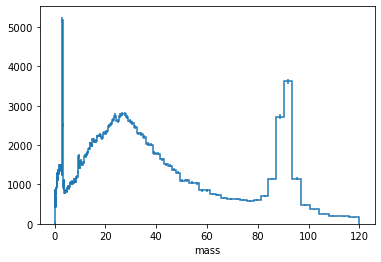

In [19]:
m1, m2 = ak.unzip(ak.combinations(muons2, 2))
hist.Hist.new.Log(200, 0.1, 120, name="mass").Double().fill(
    ak.flatten((m1 + m2).mass)
).plot()

<br><br><br>

## Awkward Arrays and Vector in Numba

Remember Numba, the JIT-compiler from [1-python-performance.ipynb](1-python-performance.ipynb)? Awkward Array and Vector have been implemented in Numba's compiler.

In [20]:
import numba as nb

@nb.njit
def first_big_dimuon(events):
    for event in events:
        for i in range(len(event)):
            mu1 = event[i]
            for j in range(i + 1, len(event)):
                mu2 = event[j]
                dimuon = mu1 + mu2
                if dimuon.mass > 10:
                    return dimuon

In [21]:
first_big_dimuon(muons2)

vector.obj(pt=8.79338264465332, phi=1.8283271789550781, eta=0.48550859093666077, mass=34.41546777888355)